## 0.Importar librerias

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import nltk
import seaborn as sns
import re
import string
import random
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.feature_extraction.text import CountVectorizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from collections import Counter
from wordcloud import WordCloud
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix



# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Usuario\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

## 1. Adquisicion y Exploracion de datos

### 1. carga de datasets
#### Reduccion a un 20% del dataset original para reducir el tiempo de procesamiento

In [2]:
# Función para cargar el dataset con nombres de columnas personalizados
def load_dataset(file_path):
    return pd.read_csv(file_path, header=None, names=['class', 'text'])

# Cargar los datasets de entrenamiento y prueba
train_df = load_dataset('train.csv')
test_df = load_dataset('test.csv')
print ("Dataset de entrenamiento original: ", train_df.shape)
print ("Dataset de prueba original: ", test_df.shape)

## Reduccion del taño del dataset a un 20% de cada uno para acelerar el procesamiento
train_df = train_df.sample(frac=0.2, random_state=42)
test_df = test_df.sample(frac=0.2, random_state=42)
print ("Dataset de entrenamiento reducido: ", train_df.shape)
print ("Dataset de prueba reducido: ", test_df.shape)
# Mostrar las primeras filas y la información básica de los datasets
print("Dataset de entrenamiento:")
train_df.sample(4)


Dataset de entrenamiento original:  (560000, 2)
Dataset de prueba original:  (38000, 2)
Dataset de entrenamiento reducido:  (112000, 2)
Dataset de prueba reducido:  (7600, 2)
Dataset de entrenamiento:


,class,text
152118,2,After Dying of thirst i wanted a shake. Ive kn...
75335,1,The quilting side is small with not a very lar...
303848,2,Piatto Verde is great cheap and cheerful tradi...
421632,2,Came to the day club with a big group of guys ...


In [3]:
## convertir las clases a valores binarios, clase 2 = 1, clase 1 = 0
train_df['encoded_class'] = train_df['class'].apply(lambda x: 1 if x == 2 else 0)
test_df['encoded_class'] = test_df['class'].apply(lambda x: 1 if x == 2 else 0)
print("Dataset de entrenamiento:")
pd.set_option('display.max_colwidth', None)
train_df.value_counts('encoded_class', normalize=True)

Dataset de entrenamiento:


encoded_class
0    0.501625
1    0.498375
Name: proportion, dtype: float64

### 2. Análisis Exploratorio de Datos (EDA)

#### Definicion de funciones

In [4]:
def perform_eda(df, title, column='text'):
    print(f"\nEDA para {title}")
    
    # Verificar las columnas disponibles
    print("Columnas disponibles:", df.columns.tolist())
    
    # Distribución de clases
    plt.figure(figsize=(10, 6))
    sns.countplot(x='class', data=df)
    plt.title(f'Distribución de Clases - {title}')
    plt.show()

    # Longitud de los textos
    df['text_length'] = df[column].apply(len)
    plt.figure(figsize=(10, 6))
    sns.histplot(df['text_length'], bins=50)
    plt.title(f'Distribución de Longitudes de Textos - {title}')
    plt.xlabel('Longitud de Texto')
    plt.show()

    # Estadísticas básicas de la longitud de los textos
    print("\nEstadísticas de longitud de textos:")
    print(df['text_length'].describe())

    # Correlación entre longitud de texto y clase
    correlation = df['text_length'].corr(df['class'])
    print(f"\nCorrelación entre longitud de texto y clase: {correlation:.4f}")

    # Insights
    print("\nInsights:")
    print("1. Distribución de clases")
    print("2. Distribución de longitudes de textos")
    print("3. Relación entre longitud de texto y clase")



def quick_text_analysis(df, title, sample_size=1000, ngram_range=(1, 2), column='text'):
    print(f"\nAnálisis rápido de texto para {title}")
    
    # Tomar una muestra aleatoria de comentarios
    sample_texts = random.sample(df[column].tolist(), min(sample_size, len(df)))
    
    # Crear un vectorizador para n-gramas
    vectorizer = CountVectorizer(ngram_range=ngram_range, stop_words='english')
    
    # Ajustar y transformar los textos de la muestra
    ngrams = vectorizer.fit_transform(sample_texts)
    
    # Obtener los n-gramas más comunes
    sum_words = ngrams.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vectorizer.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    # Mostrar los 20 n-gramas más comunes
    top_ngrams = words_freq[:20]
    
    plt.figure(figsize=(12, 6))
    sns.barplot(x=[x[1] for x in top_ngrams], y=[x[0] for x in top_ngrams])
    plt.title(f'Top 20 N-gramas Más Comunes - {title}\n(Muestra de {sample_size} comentarios)')
    plt.xlabel('Frecuencia')
    plt.ylabel('N-grama')
    plt.show()
    
    # Calcular la cantidad de palabras por texto
    word_counts = [len(text.split()) for text in sample_texts]
    
    # Crear el gráfico de distribución de la cantidad de palabras
    plt.figure(figsize=(12, 6))
    sns.histplot(word_counts, kde=True, bins=30)
    plt.title(f'Distribución de la Cantidad de Palabras por Texto - {title}\n(Muestra de {sample_size} comentarios)')
    plt.xlabel('Cantidad de Palabras')
    plt.ylabel('Frecuencia')
    plt.show()
    
    print("\nInsights:")
    print(f"1. N-gramas más comunes en una muestra de {sample_size} comentarios")
    print("2. Posibles temas o frases recurrentes en los comentarios")
    print(f"3. La longitud promedio de los textos es de {np.mean(word_counts):.2f} palabras")
    print(f"4. La mediana de la longitud de los textos es de {np.median(word_counts):.2f} palabras")
    print(f"5. El texto más corto tiene {min(word_counts)} palabras y el más largo tiene {max(word_counts)} palabras")



Análisis rápido de texto para Dataset de Entrenamiento


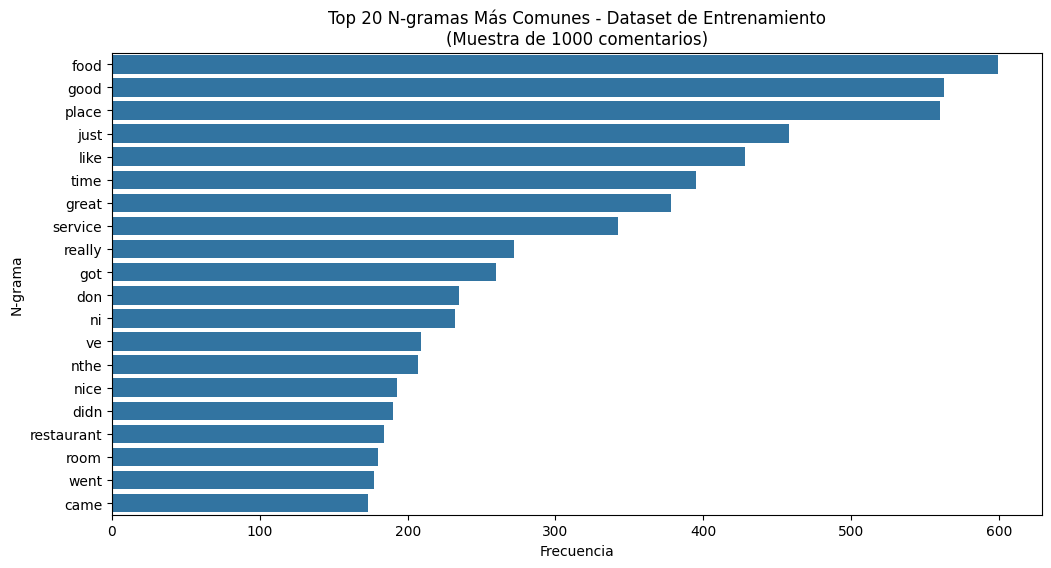

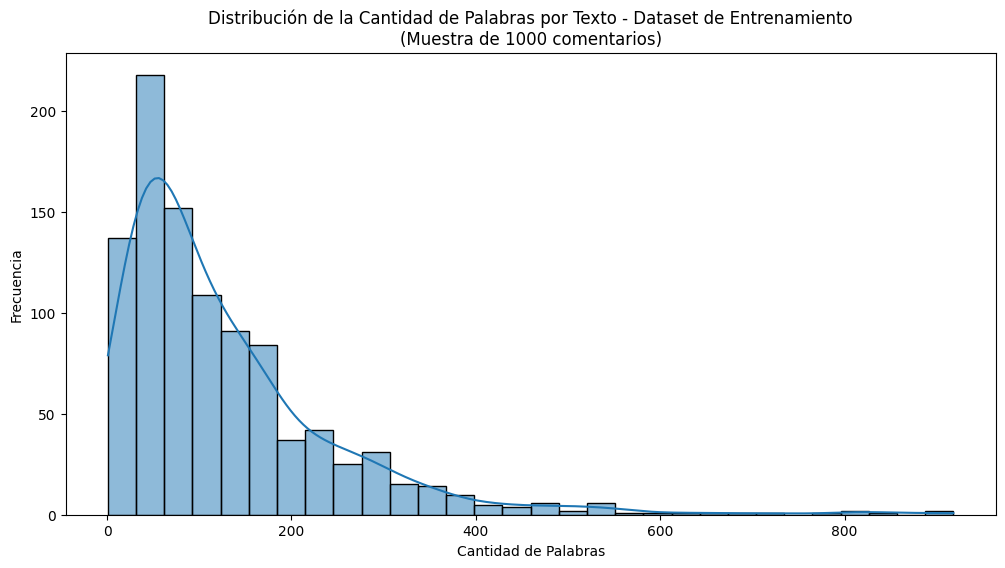


Insights:
1. N-gramas más comunes en una muestra de 1000 comentarios
2. Posibles temas o frases recurrentes en los comentarios
3. La longitud promedio de los textos es de 128.54 palabras
4. La mediana de la longitud de los textos es de 92.00 palabras
5. El texto más corto tiene 1 palabras y el más largo tiene 918 palabras


In [5]:
# Realizar análisis rápido en los datasets de entrenamiento y prueba
quick_text_analysis(train_df, "Dataset de Entrenamiento")


EDA para Dataset de Entrenamiento
Columnas disponibles: ['class', 'text', 'encoded_class']


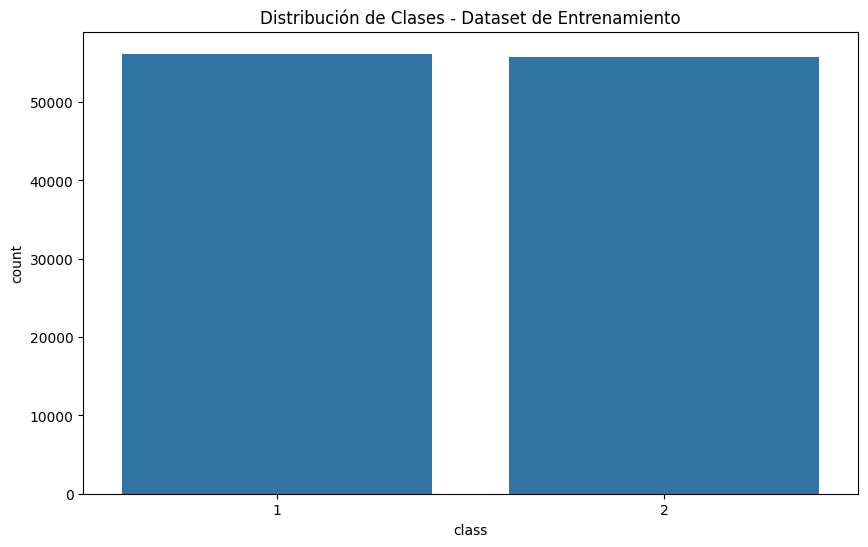

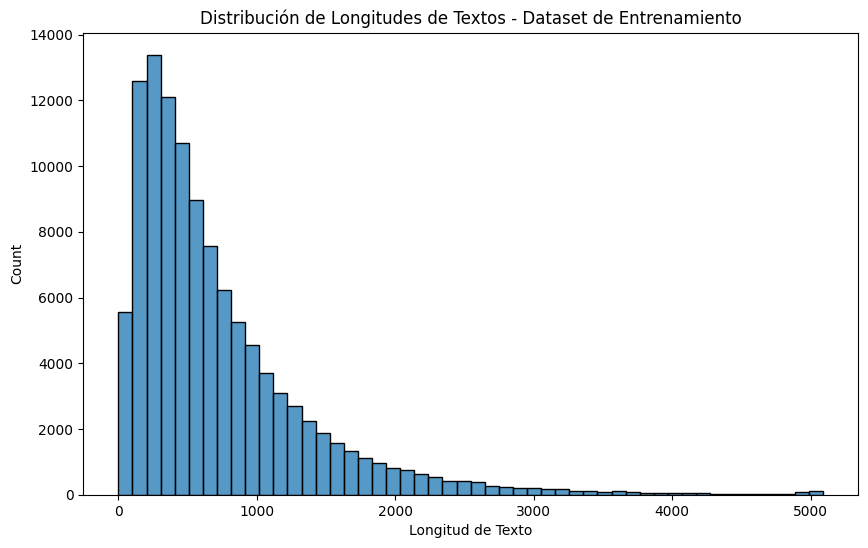


Estadísticas de longitud de textos:
count    112000.00000
mean        727.35083
std         670.12592
min           1.00000
25%         279.00000
50%         526.00000
75%         951.00000
max        5088.00000
Name: text_length, dtype: float64

Correlación entre longitud de texto y clase: -0.1440

Insights:
1. Distribución de clases
2. Distribución de longitudes de textos
3. Relación entre longitud de texto y clase


In [6]:
# Realizar EDA en los datasets de entrenamiento y prueba
perform_eda(train_df, "Dataset de Entrenamiento")


Análisis rápido de texto para Dataset de Prueba


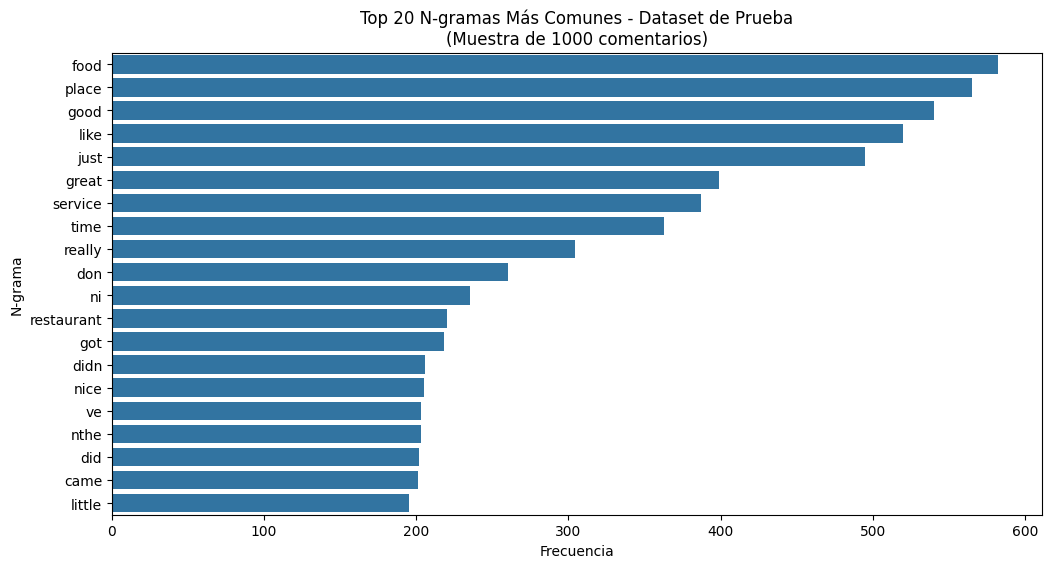

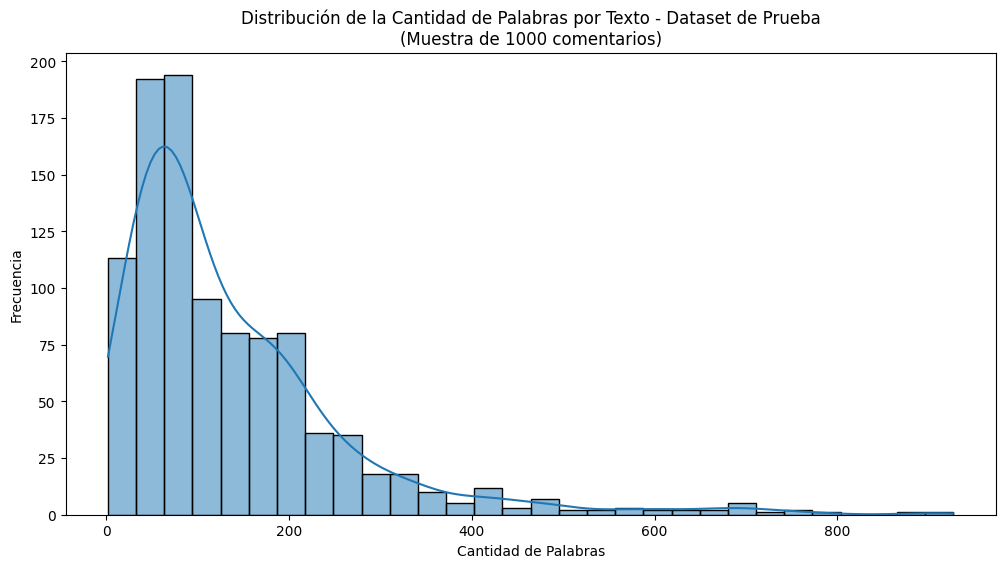


Insights:
1. N-gramas más comunes en una muestra de 1000 comentarios
2. Posibles temas o frases recurrentes en los comentarios
3. La longitud promedio de los textos es de 137.14 palabras
4. La mediana de la longitud de los textos es de 95.00 palabras
5. El texto más corto tiene 2 palabras y el más largo tiene 927 palabras


In [7]:
quick_text_analysis(test_df, "Dataset de Prueba")

## Insights del EDA inicial sobre el entrenamiento:
- Vemos que el dataset esta bastante balanceado entre comentarios clasificados como positivos y negativos
- Entre los 20 n-gramas más comúnes vemos palabras coo food, service y restaurant lo cual es consistente con que sean reseñas de yelp
- Entre el top 20 n-gramas vemos adjetivos calificativos positivos como good, great que nos llevan a pensar que hay una tendencia hacia las opiniones positivas
- Entre el top 20 no hya bigramas, lo cual es llamativo e hicimos una doble revision de la funcion y no habria indicativos de tratrase de un error 
- Entre la longitud de los comentarios vemos que con una mediana de 95 palabras y un promedio de 137 palabras, son reseñas largas lo cual debera ser tomado en consideración en la seleccion del modelo que sea capaz de capturar relaciones en contextos de estas longitudes

## 2. Preprocesamiento de datos

- Definir funcion de preprocesamiento para limpiar los comentarios de signos, stopwords y llevar todo a minusculas.
- En esta version final buscamos una forma de reducir el tiempo de computo que en la version original para ambos dataset llegaba a los 10 minutos.
- Para esto usamos un

In [8]:
## FUNCION DE PREPROCESAMIENTO DE TEXTO
def preprocess_text(text):
    # Convertir a minúsculas y eliminar puntuación
    text = text.lower()
    text = text.translate(str.maketrans('', '', string.punctuation))
    # Tokenizar
    tokens = word_tokenize(text)
    # Eliminar stop words
    stop_words = set(stopwords.words('english'))
    tokens = [t for t in tokens if t not in stop_words]
    return tokens

Verificamos el funcionamiento de la funcion de preprocesamiento

In [9]:
## crear una variable aleatorio en el rango de cantidad de registro en train_df
random_index = random.randint(0, len(train_df)-1)  # Subtract 1 from the length to ensure it's within the valid range
# Check if the random_index is within the valid range
if random_index < len(train_df):
    # Obtener un texto aleatorio
    random_text = train_df.iloc[random_index]['text']
    print("Texto Aleatorio:")
    print(random_text)
    print("\nPreprocesamiento:")
    print(preprocess_text(random_text))
else:
    print("Invalid random index.")

Texto Aleatorio:
One of the best places I've eaten at. We came later than what we reserved and they still sat us. Very grateful for that.\n\nI literally had a meal 2 hours before this, but when I saw the food, I got hungry all over again.\n\nOur dinner started around sunset and the view outside was magnificent. It was so breathtaking.\n\nI love love love love the bread and butter. The different types were a joy to try. My favorite was the orange ginger butter... and it was my group's favorite too!\n\nThe entrees were what was expected. I had the pork chops. They were delicious. It was a little dry, but the sauce and fruit made it all better. I tried a bit of the salmon and I suggest that a whole lot more.\n\nWe were all so full from the entree that we couldn't fit in dessert, even though they are every small.\n\nOur waitress, Ellen, made the whole experience a lot more welcoming and memorable. She was super friendly and chatted with us from time to time, seeing how we are doing and suc

Procesamos el dataset completo almacenando en una columna adicional para conservar la trazabilidad

In [10]:
## preprocesamos el text en una nueva columna
train_df['processed_text'] = train_df['text'].apply(preprocess_text)
test_df['processed_text'] = test_df['text'].apply(preprocess_text)
print("Dataset de entrenamiento:")
train_df.sample(4)

Dataset de entrenamiento:


,class,text,encoded_class,text_length,processed_text
255139,1,"Decent happy hour for hit and miss food. I received a burned quesadilla, but other folks around me looked to be enjoying their half -off appetizers. $3 PBR was great, especially on a hot day. Live entertainment that afternoon was provided by a generic cover songs guitarist/vocalist -- I didn't catch her name, but people liked her. I didn't, but I'm an intolerable snob about these things. If I were drunk, and I'd stumbled up the escalators and somehow got served more drinks, I'd probably love the place. But I was sober and in a hurry. Service was slow and unenthused.",0,572,"[decent, happy, hour, hit, miss, food, received, burned, quesadilla, folks, around, looked, enjoying, half, appetizers, 3, pbr, great, especially, hot, day, live, entertainment, afternoon, provided, generic, cover, songs, guitaristvocalist, didnt, catch, name, people, liked, didnt, im, intolerable, snob, things, drunk, id, stumbled, escalators, somehow, got, served, drinks, id, probably, love, place, sober, hurry, service, slow, unenthused]"
345460,2,"Me and my dad have become regulars at this place. The atmosphere is always great and we are never disappointed with the food or service. We go to trivia night on wednesday nights and always have a blast- good food, drinks and people. I'd recommend this place to anyone!!!",1,271,"[dad, become, regulars, place, atmosphere, always, great, never, disappointed, food, service, go, trivia, night, wednesday, nights, always, blast, good, food, drinks, people, id, recommend, place, anyone]"
300847,1,"I wasn't impressed with my only dining experience here. Fancy decor, fancy people, bizarre Scottish-Thai fusion cuisine, rude staff and a stiff bill...",0,151,"[wasnt, impressed, dining, experience, fancy, decor, fancy, people, bizarre, scottishthai, fusion, cuisine, rude, staff, stiff, bill]"
348001,1,"Good food, if you can get attention. One guy that works there pays no attention to the register and after 10 min waiting, LOOKING at him just staring at the computer behind the bar, made me decide I'll wait and maybe next time I go for a haircut they will be paying attention... :(",0,281,"[good, food, get, attention, one, guy, works, pays, attention, register, 10, min, waiting, looking, staring, computer, behind, bar, made, decide, ill, wait, maybe, next, time, go, haircut, paying, attention]"


In [11]:
train_df.sample(4)

,class,text,encoded_class,text_length,processed_text
36531,2,"Phenomenal, cheap, fast hangover food. This place totally reminds of a diner that you would see in a tiny little town where everyone knows each other. The servers are friendly, there are lots of options for different egg substitutes, and the service is quick. I would definitely recommend this to anyone who woke up in a random apartment in Old Town, and needs some food quick! One quick reminder though - be sure to bring your check book or cash!! They do not take credit.",1,478,"[phenomenal, cheap, fast, hangover, food, place, totally, reminds, diner, would, see, tiny, little, town, everyone, knows, servers, friendly, lots, options, different, egg, substitutes, service, quick, would, definitely, recommend, anyone, woke, random, apartment, old, town, needs, food, quick, one, quick, reminder, though, sure, bring, check, book, cash, take, credit]"
406984,2,"Pho Nam opened less than a week ago, but I'd say they're off to a phenomenal start! Puns aside, I'm a huge pho fan and have been a little disappointed with Madison's offerings in the Vietnamese arena. Enter Pho Nam's delicious, fragrant, and very comforting pho noodle soup ($6.75) that I had this afternoon--my new fave! The broth was complex, the noodles extra thin, and the beef came medium rare and very tender.\n\nThe restaurant space, located in the same complex as Hu Hot Mongolian Grill, is bright and calming with many windows and high ceilings, allowing for a lot of natural light. This is key to me, and I find that Saigon Noodles and Ha Long Bay both fail in this ambiance department. If it's a lazy weekend afternoon, if I had one too many drinks the night before, I need a clean and welcoming space in which to recover with my restorative pho.\n\nThe best part of our first visit? Free appetizers! During their first month of opening, Pho Nam is giving away one free appetizer with each order. So for the two of us dining, we received two appetizers! The fresh spring rolls ($3.25) are amazing, but I wouldn't recommend the \""Bread Deep Fried Special\"" ($4.75). I don't know what we were thinking when we ordered it (should have just gone with the egg rolls!) but it was basically very greasy toast squares with a ground pork/pea pod/egg/onion topping. Next time, I think I'll try the green papaya salad instead. I also want to try their Wonton Soup ($4.75) and their Grilled Pork Vermicelli Noodle dish ($7.25).\n\nOn our way out the door, the owner asked us how everything was and inquired if we had any advice, since they were just opening. I mentioned that we'd love to see some spicy chili sauce as a condiment on the tables. But I forgot to also request cream puffs on the dessert menu! Oh well, there's always next time.",1,1841,"[pho, nam, opened, less, week, ago, id, say, theyre, phenomenal, start, puns, aside, im, huge, pho, fan, little, disappointed, madisons, offerings, vietnamese, arena, enter, pho, nams, delicious, fragrant, comforting, pho, noodle, soup, 675, afternoonmy, new, fave, broth, complex, noodles, extra, thin, beef, came, medium, rare, tendernnthe, restaurant, space, located, complex, hu, hot, mongolian, grill, bright, calming, many, windows, high, ceilings, allowing, lot, natural, light, key, find, saigon, noodles, ha, long, bay, fail, ambiance, department, lazy, weekend, afternoon, one, many, drinks, night, need, clean, welcoming, space, recover, restorative, phonnthe, best, part, first, visit, free, appetizers, first, month, opening, pho, nam, giving, ...]"
278887,2,"There are a few other burger spots in my area, but I like Red Robin best of all. The burger is just really good. What more do you need to know. I recommend the bbq one with bbq sauce and onion strings on it. Ok I want one now. Perfect for kids too with cool decor to look at and good selection of items on their menu.",1,321,"[burger, spots, area, like, red, robin, best, burger, really, good, need, know, recommend, bbq, one, bbq, sauce, onion, s

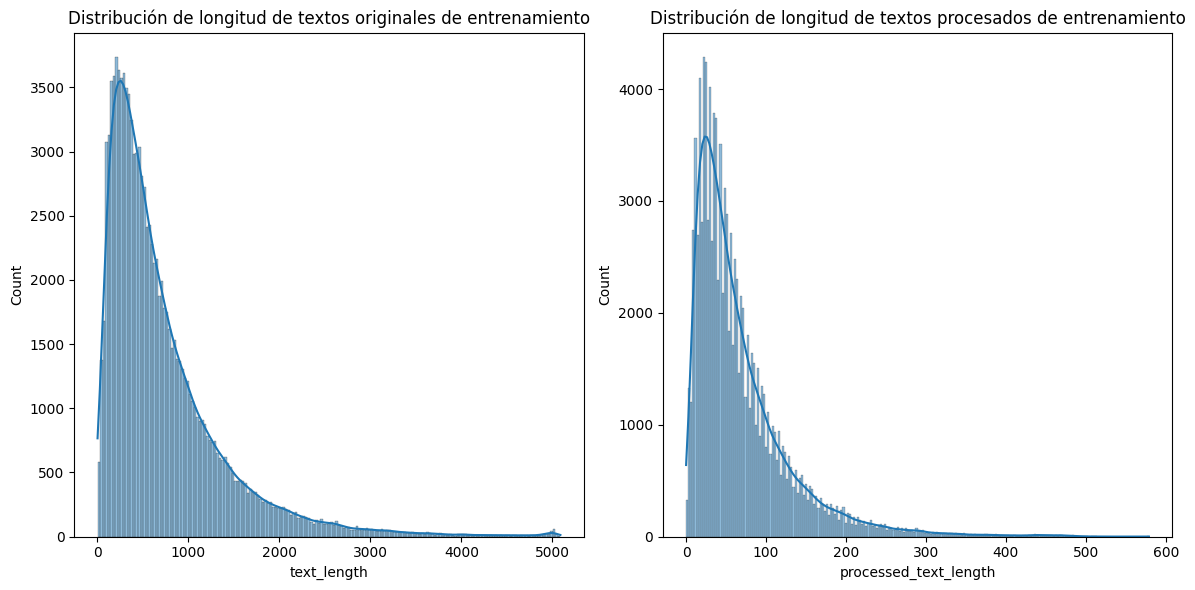

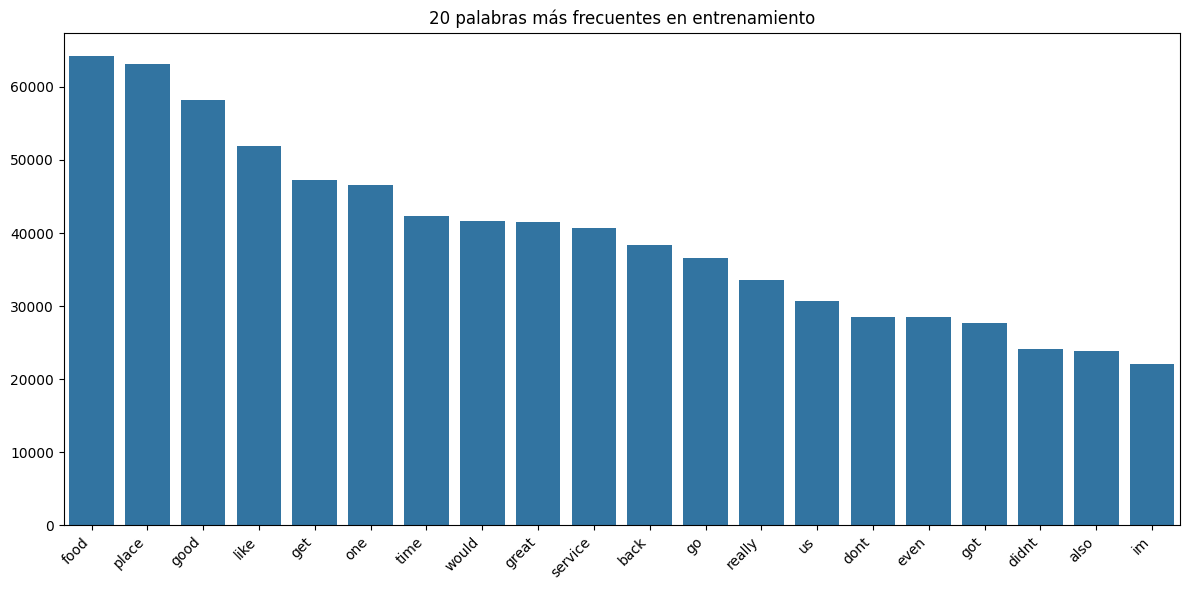

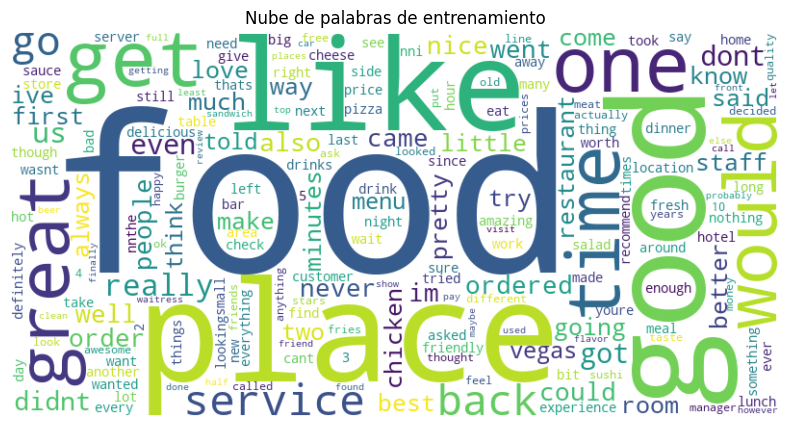

Tamaño del vocabulario de entrenamiento: 234551
Tamaño del vocabulario de prueba: 39983
Palabras en prueba pero no en entrenamiento: 11080
Porcentaje de palabras de prueba no vistas en entrenamiento: 27.71%


In [12]:
def perform_eda(train_df, test_df):
    # 1. Análisis de longitud de textos
    train_df['text_length'] = train_df['text'].apply(len)
    train_df['processed_text_length'] = train_df['processed_text'].apply(len)
    
    plt.figure(figsize=(12, 6))
    plt.subplot(1, 2, 1)
    sns.histplot(train_df['text_length'], kde=True)
    plt.title('Distribución de longitud de textos originales de entrenamiento')
    plt.subplot(1, 2, 2)
    sns.histplot(train_df['processed_text_length'], kde=True)
    plt.title('Distribución de longitud de textos procesados de entrenamiento')
    plt.tight_layout()
    plt.show()

    # 2. Análisis de frecuencia de palabras
    all_words = [word for tokens in train_df['processed_text'] for word in tokens]
    word_freq = Counter(all_words)
    
    plt.figure(figsize=(12, 6))
    word_freq.most_common(20)
    sns.barplot(x=[word[0] for word in word_freq.most_common(20)], 
                y=[word[1] for word in word_freq.most_common(20)])
    plt.title('20 palabras más frecuentes en entrenamiento')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

    # 3. Nube de palabras
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title('Nube de palabras de entrenamiento')
    plt.show()

    # 4. Comparación entre conjuntos de entrenamiento y prueba
    train_vocab = set([word for tokens in train_df['processed_text'] for word in tokens])
    test_vocab = set([word for tokens in test_df['processed_text'] for word in tokens])
    
    print(f"Tamaño del vocabulario de entrenamiento: {len(train_vocab)}")
    print(f"Tamaño del vocabulario de prueba: {len(test_vocab)}")
    print(f"Palabras en prueba pero no en entrenamiento: {len(test_vocab - train_vocab)}")
    print(f"Porcentaje de palabras de prueba no vistas en entrenamiento: {len(test_vocab - train_vocab) / len(test_vocab) * 100:.2f}%")

# Ejecutar el EDA
perform_eda(train_df, test_df)

## 3. Feature Engineering

Este proceso es clave para:
- Las clases ya fueron llevadas a binarios en la carga de datos con onne hot encoding por lo cual aca no sera necesario
- Convertir los feedbacks en vectores numericos para poder ser procesados por el modelo y definiendo un vocabulario maximo a utlizar de 10.000 palabras mas frecuentes y una longitud maxima de secuencias de 200 posterior a la tokenizacion

In [13]:
# Tokenización y padding
max_words = 10000
max_len = 200

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(train_df['processed_text'])

X_train = tokenizer.texts_to_sequences(train_df['processed_text'])
X_test = tokenizer.texts_to_sequences(test_df['processed_text'])

X_train_pad = pad_sequences(X_train, maxlen=max_len)
X_test_pad = pad_sequences(X_test, maxlen=max_len)

y_train = train_df['encoded_class'].values
y_test = test_df['encoded_class'].values

print("Forma de los datos de entrenamiento:", X_train_pad.shape)
print("Forma de los datos de prueba:", X_test_pad.shape)

Forma de los datos de entrenamiento: (112000, 200)
Forma de los datos de prueba: (7600, 200)


## 4. Desarrollo del modelo inicial
- La capa de Embedding convierte palabras en vectores densos, capturando relaciones semánticas.
- Las capas LSTM procesan secuencias de texto, manteniendo contexto a largo plazo. Se usan dos capaz decrementales en el numero de unidades de cada una como practica común y el número de unidades se define en base a la longitud del texto y el tamaño del dataset
- La capa densa final con sigmoid realiza la clasificación binaria de sentimientos ya que nuestro dataset solo tiene sentimiento positivo o negativo.
- En la compilacion usamos binary_crossentrpy ya que nuestro caso de uso busca una interpretacion binaria, buscando optimizar la metrica de accuracy y reservando un un 10% para validacion en el entrenamiento para prevenir overfit

Epoch 1/4


c:\Users\Usuario\OneDrive\Proyectos\Curso-NLP-Deep-Learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


1575/1575 ━━━━━━━━━━━━━━━━━━━━ 103s 64ms/step - accuracy: 0.8249 - loss: 0.3871 - val_accuracy: 0.9129 - val_loss: 0.2222
Epoch 2/4
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 90s 57ms/step - accuracy: 0.9276 - loss: 0.1869 - val_accuracy: 0.9127 - val_loss: 0.2217
Epoch 3/4
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 108s 69ms/step - accuracy: 0.9411 - loss: 0.1524 - val_accuracy: 0.9197 - val_loss: 0.1979
Epoch 4/4
1575/1575 ━━━━━━━━━━━━━━━━━━━━ 87s 55ms/step - accuracy: 0.9539 - loss: 0.1230 - val_accuracy: 0.9212 - val_loss: 0.2132
Test accuracy: 0.9178


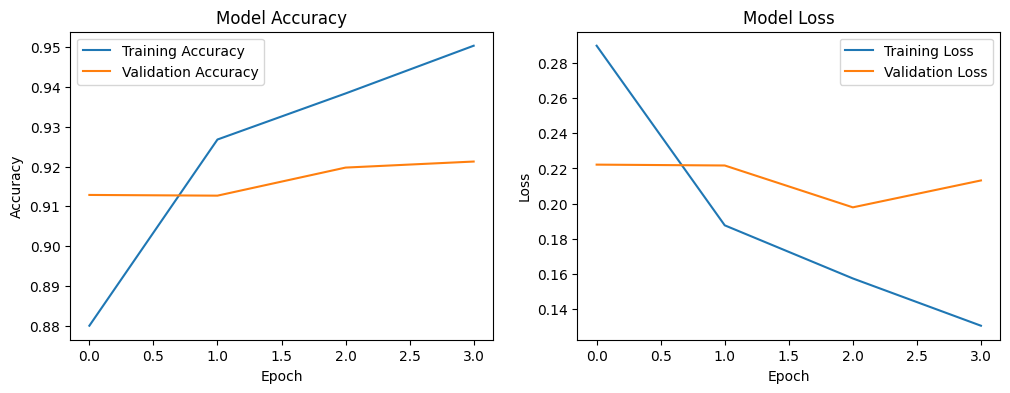

In [14]:
# Define the model
model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    LSTM(64, return_sequences=True),
    LSTM(32),
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train_pad, y_train, epochs=4, batch_size=64, validation_split=0.1, verbose=1)

# Evaluate the model
loss, accuracy = model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Test accuracy: {accuracy:.4f}')

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

### Muestras de las predicciones
La siguiente funcion permite predecir 10 ejemplos y mostrar el texto original y el sentimiento real vs predicto

In [15]:
# Function to convert binary class to sentiment label
def get_sentiment_label(class_value):
    return "Positive" if class_value == 1 else "Negative"

# Make predictions
y_pred_proba = model.predict(X_test_pad)
y_pred_classes = (y_pred_proba > 0.5).astype(int).flatten()

# Get the original text, real class, and predicted class for the last 10 examples
last_10_indices = test_df.index[-10:]
original_texts = test_df.loc[last_10_indices, 'text'].tolist()
real_classes = y_test[-10:]
predicted_classes = y_pred_classes[-10:]

# Print the results
print("Last 10 predictions:")
print("=" * 80)
for text, real, pred in zip(original_texts, real_classes, predicted_classes):
    real_sentiment = get_sentiment_label(real)
    pred_sentiment = get_sentiment_label(pred)
    print(f"Text: {text[:50]}...")  # Print first 50 characters of the text
    print(f"Real sentiment: {real_sentiment}")
    print(f"Predicted sentiment: {pred_sentiment}")
    print("-" * 80)

238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Last 10 predictions:
Text: Stopped on my way home for pizza and a Greek salad...
Real sentiment: Negative
Predicted sentiment: Negative
--------------------------------------------------------------------------------
Text: Service at this Denny's was dismal. After waiting ...
Real sentiment: Negative
Predicted sentiment: Negative
--------------------------------------------------------------------------------
Text: After having had lunch at the Grill at Eagle Mount...
Real sentiment: Negative
Predicted sentiment: Negative
--------------------------------------------------------------------------------
Text: Had the roasted chicken lasagna and wife had parme...
Real sentiment: Positive
Predicted sentiment: Positive
--------------------------------------------------------------------------------
Text: Went for happy hour the other day. $3 margaritas, ...
Real sentiment: Positive
Predicted sentiment: Positive
--------------------------------------

### Evaluacion del modelo
La siguiente funcion permite evaluar el modelo con el dataset de test y obtener las metricas de performance

In [16]:
def evaluate_sentiment_model(model_name, model, X_test, y_test, threshold=0.5):
    # Hacer predicciones
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > threshold).astype(int)
    
    # Calcular métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_pred_proba)
    
    # Crear reporte
    print(f"Reporte de Evaluación para el modelo: {model_name}")
    print("=" * 50)
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1-Score: {f1:.4f}")
    print(f"AUC-ROC: {auc:.4f}")
    
    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f'Matriz de Confusión - {model_name}')
    plt.xlabel('Predicción')
    plt.ylabel('Valor Real')
    plt.show()
    
    # Distribución de probabilidades
    plt.figure(figsize=(8, 6))
    sns.histplot(y_pred_proba, kde=True, bins=50)
    plt.axvline(x=threshold, color='r', linestyle='--', label='Umbral')
    plt.title(f'Distribución de Probabilidades - {model_name}')
    plt.xlabel('Probabilidad de Sentimiento Positivo')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.show()
    
    return {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1': f1,
        'auc': auc
    }

# Ejemplo de uso:
# evaluate_sentiment_model('LSTM Binario', binary_model, X_test_pad, y_test)

238/238 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
Reporte de Evaluación para el modelo: Modelo inicial
Accuracy: 0.9178
Precision: 0.9202
Recall: 0.9147
F1-Score: 0.9174
AUC-ROC: 0.9748


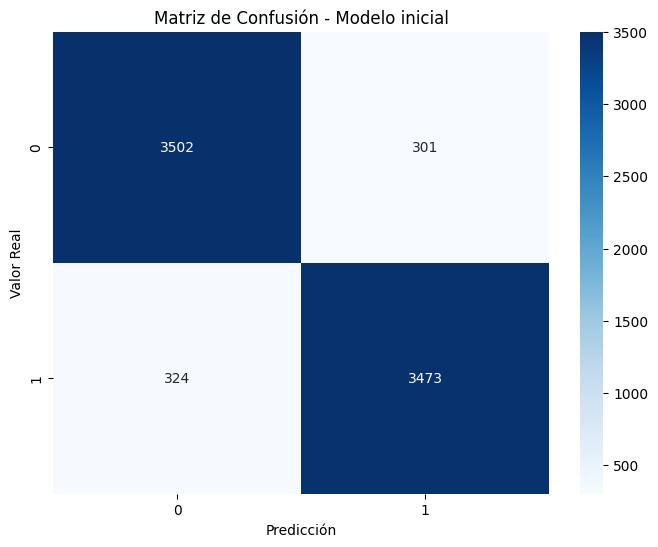

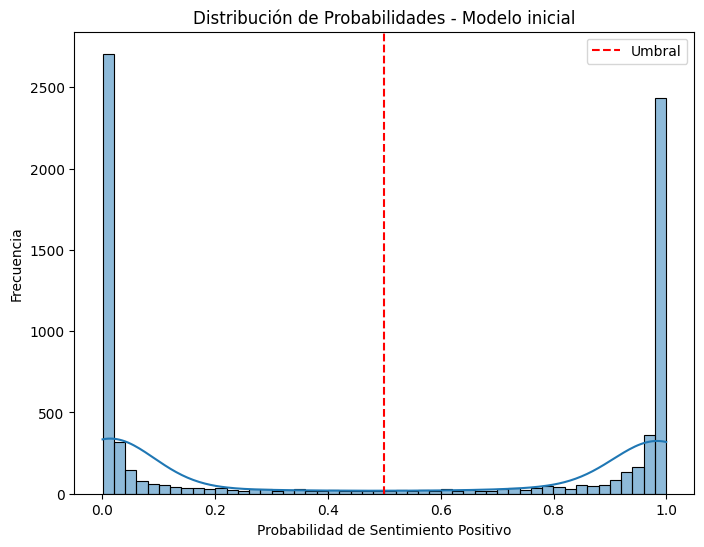

{'accuracy': 0.9177631578947368,
 'precision': 0.9202437731849497,
 'recall': 0.914669475902028,
 'f1': 0.9174481574428741,
 'auc': 0.9748087793129511}

In [17]:
results = evaluate_sentiment_model('Modelo inicial', model, X_test_pad, y_test)
results

## 5.Mejora del modelo
Las mejoras buscadas en el modelo son las siguientes:
- Mejor regularizacion al añadir Dropout en 2 capaz para prevenir sobreajuste
- Al añadir una capa adicional Dense entre las LSTM, el modelo es capaz de capturar relaciones más complejas en el texto
- Al añadir el EarlyStopping y ReduceLROnPlateau lo que buscamos es mejorar la prevencion del sobreajuste y una convergencia del modelo mas eficiente ya que el modelo original tomo 10 minutos de entrenamiento
- Al aumentar el validation_split a 20% damos mayor confiabilidad a la evaluacion del modelo en entrenamiento

In [18]:
# Define the binary classification model
binary_model = Sequential([
    Embedding(max_words, 32, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.25),
    LSTM(32),
    Dense(16, activation='relu'),
    Dropout(0.2),
    Dense(1, activation='sigmoid')  # Cambiado a 1 unidad con activación sigmoid para clasificación binaria
])

# Compile the model
binary_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])  # Cambiado a binary_crossentropy

# Define callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=1, min_lr=0.0001)

# Train the model
binary_history = binary_model.fit(
    X_train_pad, y_train,
    epochs=4,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stopping, reduce_lr],
    verbose=1
)

# Evaluate the model
binary_loss, binary_accuracy = binary_model.evaluate(X_test_pad, y_test, verbose=0)
print(f'Binary model test accuracy: {binary_accuracy:.4f}')

Epoch 1/4


c:\Users\Usuario\OneDrive\Proyectos\Curso-NLP-Deep-Learning\.venv\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


700/700 ━━━━━━━━━━━━━━━━━━━━ 72s 99ms/step - accuracy: 0.8056 - loss: 0.4069 - val_accuracy: 0.9093 - val_loss: 0.2207 - learning_rate: 0.0010
Epoch 2/4
700/700 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 0.9291 - loss: 0.1861 - val_accuracy: 0.9098 - val_loss: 0.2221 - learning_rate: 0.0010
Epoch 3/4
700/700 ━━━━━━━━━━━━━━━━━━━━ 67s 96ms/step - accuracy: 0.9469 - loss: 0.1444 - val_accuracy: 0.9153 - val_loss: 0.2183 - learning_rate: 2.0000e-04
Epoch 4/4
700/700 ━━━━━━━━━━━━━━━━━━━━ 66s 95ms/step - accuracy: 0.9545 - loss: 0.1290 - val_accuracy: 0.9148 - val_loss: 0.2269 - learning_rate: 2.0000e-04
Binary model test accuracy: 0.9205


238/238 ━━━━━━━━━━━━━━━━━━━━ 4s 16ms/step
Reporte de Evaluación para el modelo: Modelo mejorado
Accuracy: 0.9205
Precision: 0.9270
Recall: 0.9128
F1-Score: 0.9199
AUC-ROC: 0.9767


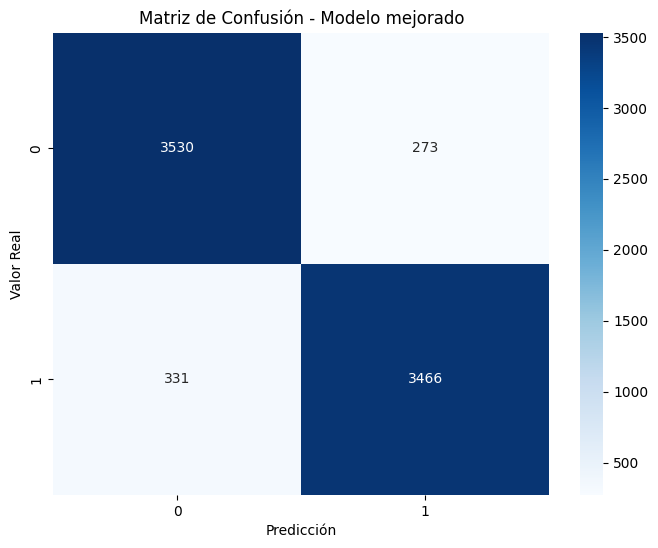

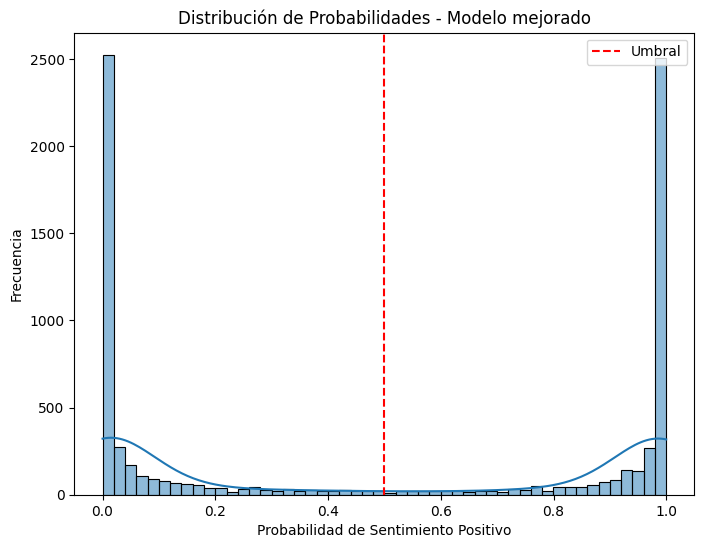

In [19]:
results = evaluate_sentiment_model('Modelo mejorado', binary_model, X_test_pad, y_test)

## Conclusiones del modelo mejorado
- Ambos modelos muestran resultados aceptables; Sin embargo, en este modelo mejorado alcanzamos una capacidad de predicción (accuracy) de 92.2% con una capacidad ligeramente superior para predicir correctamente sentimientos positivos (precision) de 92.74% y ua perfomance buena pero ligeramente inferior para acertar los sentimientos negativos (Recall) 91.2%
- El modelo mejorado particularmente destacada en términos de eficiencia ya que si bien la mejora en las métricas de performance son marginales, la reducción del tiempo de entrenamiento del modelo es drástica de un 53%
- Este modelo ya entrenado ha demostrado un excelente poder predictivo en la clasificacion de feedbacks nuevos, por lo cual es posible usarlo por la organización en producción para poder clasificar de forma automática y en tiempo real o en bloques diarios para la elaboracion de alertas y reportes sin supervisión humana
- Se recomienda un re-entrenamiento rutinario del modelo para mantener la performance dada la evolucion natural del negocio de servicios ofrecidos,  las audiencias de usuarios y los volúmenes de datos 